In [2]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from scipy import stats
from lmfit import Model
from lmfit import Parameters

In [3]:
tick_style = {'direction' : 'in', 
			 'length' : 4, 
			 'width' : 0.7, 
			 'colors' : 'black'}

r = 8.314 
bold = '\033[1m' #for making text bold
unbold = '\033[0m' #for removing bold text

##############################################################################
########################### Isotherm models ##################################
##############################################################################

########## x is pressure ##############

#Single site langmuir forms
def single_langmuir(x, q, b):
    return  (q * b * x) / (1 + b * x)

def linear_langmuir1(x, q, b):
    return ( (x / (b * q) ) + (1 / (q) ) )

def linear_langmuir2(x, q, b):
    return ( (1 / (b * q) ) + (x / (q) ) )

#Single site langmuir form with van't Hoff form
def deltaH_langmuir(x, t, q, b0, h):
    b = b0*np.exp(-h/(r*t))
    return q * ( (b * x) / (1 + b * x) )

###############################################
# Dual site langmuir forms -  normal and van't Hoff form
def dsl(x, q1, q2, b1, b2):
    site1 = q1*( (b1 * x) / (1 + b1 * x) )
    site2 = q2*( (b2 * x) / (1 + b2 * x) )
    return site1 + site2

def dsl_h(x, t, q1, q2, h1, h2, b01, b02):
    b1 = b01 * np.exp(-h1 / (r * t) )
    b2 = b02 * np.exp(-h2 / (r * t) )
    site1 = q1*( (b1 * x) / (1 + b1 * x) )
    site2 = q2*( (b2 * x) / (1 + b2 * x) )
    return site1 + site2

#################################################


def mdr_temp(x, t, n0, n1, a, b, e):
    k = (r*t)/(b*e)
    term1a = (1 - np.exp( - a * x) )* n0
    term1b = np.exp((-k * ((np.log(1/x))**2)))
    term2 = np.exp( - a * x) * n1 * x
    return term1a * term1b + term2

def mdr(x, n0, n1, a, c):
    term1a = (1 - np.exp( - a * x) )* n0
    term1b = np.exp((-c * ((np.log(1/x))**2)))
    term2 = np.exp( - a * x) * n1 * x
    return term1a * term1b + term2

################################################
#Calculation for b0 from obtained single langmuir parameters to be used as an initial guess for 'deltaH_langmuir'
def henry(x, kh): #Henry's law function for the henry region calculation
    return [i*kh for i in x]

def b0_calc(b, h, t):
    return np.exp(np.log(b) + h/(r*t))
    

####################### TYPE III, IV, V isotherms #################################

#BET Extension for type IV and V isotherms

# For a maximum (2n-1) layers which can be fit into a capillary:
def BET_ext1(x, c, n, g, q):
    #g = np.exp(h/(r*t))
    term1 = (c*x)/(1-x)
    term2_num = 1 + (((n * g) / 2) - n) * x**(n - 1) - (n * g - n + 1)*x**n + (n * g /2)*x**(n + 1)
    term2_den = 1 + (c - 1)*x + ((c * g/2) - c)*x**n - (c * g /2)*x**(n + 1)
    return term1 * (term2_num / term2_den) * q

# For a maximum number of 2n layers:
def BET_ext2(x, c, n, g, q):
    #g = np.exp(h/(r*t))
    term1 = (c*x)/(1-x)
    term2_num = 1 + (((n * g) / 2) - n / 2) * x**(n - 1) - (n * g + 1)*x**n + (n * g /2 + n / 2)*x**(n + 1)
    term2_den = 1 + (c - 1)*x + ((c * g/2) - c/2)*x**n - (c * g /2 + c / 2)*x**(n + 1)
    return term1 * (term2_num / term2_den) * q
    
# Do and Do isotherm
def DoDo(x, ns, kf, nu, ku, m):
    term1 = (ns * kf * x)/( (1 - x)*(1 + (kf - 1)*x))
    term2 = (nu * ku * x**m)/(1 + ku * x**m)
    return term1 + term2

def GAB(x, n, ka, ca):
    num = n * ka * ca * x
    den = (1 - ka * x) * (1 + (ca - 1) * ka * x)
    return num / den


###############################################################################
##################### EXTENDED MODELS ##################################

#Extended dual site langmuir model for the prediction of binary adsorption
#This calculates the absolute adsorption of A wrt pressure
def ext_dslA(x, t, q1A, q2A, h1A, h2A, b01A, b02A, h1B, h2B, b01B, b02B, yA):
    b1A = b01A*np.exp(-h1A/(r*t))
    b2A = b02A*np.exp(-h2A/(r*t))
    b1B = b01B*np.exp(-h1B/(r*t))
    b2B = b02B*np.exp(-h2B/(r*t))
    yB = 1 - yA    
    e1 = q1A * (b1A * x * yA) / (1 + (b1A * x * yA) + (b1B * x * yB) )
    e2 = q2A * (b2A * x * yA) / (1 + (b2A * x * yA) + (b2B * x * yB) )
    return e1 + e2

def ext_dslB(x, t, q1B, q2B, h1A, h2A, b01A, b02A, h1B, h2B, b01B, b02B, yB):
    b1A = b01A*np.exp(-h1A/(r*t))
    b2A = b02A*np.exp(-h2A/(r*t))
    b1B = b01B*np.exp(-h1B/(r*t))
    b2B = b02B*np.exp(-h2B/(r*t))
    yA = 1 - yB    
    e1 = q1B * (b1B * x * yB) / (1 + (b1B * x * yB) + (b1A * x * yA) )
    e2 = q2B * (b2B * x * yB) / (1 + (b2B * x * yB) + (b2A * x * yA) )
    return e1 + e2

def sel(qA, qB, yA):
    return (qA/qB)/(yA/(1-yA))


############# EMPIRICAL MODELS ################
def sips(x, q, b, n):
    return q * ( ( (b * x)**(1 / n) ) / (1 + (b * x)**(1 / n) ) )

def toth(x, q, b, t):
    return q * ( ( b * x) / ( (1 + (b * x)**t)**(1 / t) ) )
    
################################################################################
    
#############################################################################
######################      ERROR CALCS       ###############################
############################################################################
    
    
######### R squared calculation ###########
def r2(x, y, f, c):
    residuals = y - f(x, *c)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    result = 1 - (ss_res / ss_tot)
    if result <= 0:
        return 0.00000
    else:
        return result
def r2fix(x, y, result):
    residuals = y - result
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((y-np.mean(y))**2)
    rsq = 1 - (ss_res / ss_tot)
    return rsq

#This additional form of R squared calculation was required due to an error...
#...when using henrys law in the above function
def r2hen(pressures, uptake, f, hen):
    residuals = uptake - f(pressures, hen)
    ss_res = np.sum(residuals**2)
    ss_tot = np.sum((uptake-np.mean(uptake))**2)
    result = 1 - (ss_res / ss_tot)
    if result <= 0:
        return 0.00000
    else:
        return result
    
def mse(x, y, f, c):
    y_predicted = f(x, *c)
    return np.square(np.subtract(y, y_predicted)).mean()

def msefix(x, y, result):
    return np.square(np.subtract(y, result)).mean()
    
def get_cmap(n, name='hsv'):
    #Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    #RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)

def colours():
    return ['b', 'g', 'r', 'c', 'm', 'y', 'tab:orange', 'tab:purple', 'tab:brown', 'tab:olive'] #for plotting
colours = colours()


,T (oC),q (mmol/g),b (1/bar),"n, heterogeneity parameter",r_sq,mse
0,10,7.442500,30.008295,1.934750,0.997746,0.010347
1,40,6.899365,7.789867,1.598053,0.998832,0.005680
2,100,6.035181,1.032438,1.289677,0.999690,0.001127


_______________________________________________________________________
ΔH: -32.84 kJ/mol. R sq: 1.0


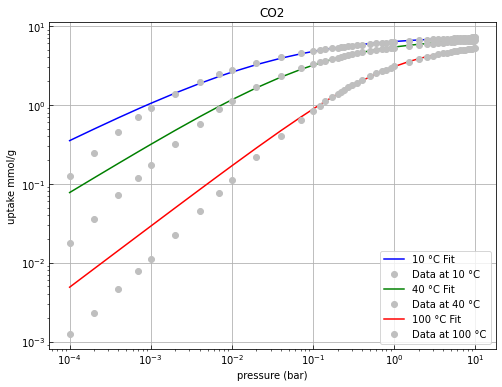

In [6]:
class Empirical:
    def __init__(self, df, compname, temps, isotherm, keyPressures, keyUptakes, guess, logplot=False):
        self.df = df
        self.compname = compname
        self.keyPressures = keyPressures
        self.keyUptakes = keyUptakes
        self.temps = temps
        self.guess = guess
    
    def isotherm_fit(self, df, compname, temps, isotherm, keyPressures, keyUptakes, guess, logplot=False):
        ##### setting up variables for fitting ####
        ###### allocating columns to lists ##### 

        #Importing data and allocating to variables
        y = []
        x = []
        for i in range(len(keyPressures)):
            x.append(df[keyPressures[i]].values)
            y.append(df[keyUptakes[i]].values)
               
        gmod = Model(isotherm)
        
        q_i = guess[0]
        b_i = guess[1]

        c = []
        result = []
        if isotherm == sips:
            n_i = guess[2]
            
            for i in range(len(keyPressures)):
                pars = Parameters()
                pars.add('q', value=q_i, min=0)
                pars.add('b', value=b_i, min=0)
                pars.add('n', value=n_i, min=0)

                results = gmod.fit(y[i], pars, x=x[i])
                cee = [results.values['q'], results.values['b'], results.values['n']]

                result.append(results)
                c.append(cee)
                del results
                del pars
                
            #FORMATTED VARIABLES
            q = [param[0] for param in c]
            b = [param[1] for param in c]
            n = [param[2] for param in c]
            ln_b = np.array([np.log(i) for i in b])
            
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results
            df_result = pd.DataFrame(list(zip(temps, q, b, n, r_sq, se)), columns=['T (oC)','q (mmol/g)','b (1/bar)',
                                                                        'n, heterogeneity parameter','r_sq', 'mse'])

            display(pd.DataFrame(df_result))
                        
        elif isotherm == toth:
            t_i = guess[2]
            
            for i in range(len(keyPressures)):
                pars = Parameters()
                pars.add('q', value=q_i, min=0)
                pars.add('b', value=b_i, min=0)
                pars.add('t', value=t_i, min=0)

                results = gmod.fit(y[i], pars, x=x[i])
                cee = [results.values['q'], results.values['b'], results.values['t']]

                result.append(results)
                c.append(cee)
                del results
                del pars
                
            #FORMATTED VARIABLES
            q = [np.round(param[0], 3) for param in c]
            b = [np.round(param[1], 2) for param in c]
            t = [np.round(param[2], 3) for param in c]
            ln_b = np.array([np.log(i) for i in b])
            
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results
            df_result = pd.DataFrame(list(zip(temps, q, b, t, r_sq, se)), columns=['T (oC)','q (mmol/g)','b (1/bar)',
                                                                        't, heterogeneity parameter','r_sq', 'mse'])


            display(pd.DataFrame(df_result))

            
        if len(temps) >= 3:
            T = np.array([1/(temp+273) for temp in self.temps])
            mH, bH, rH, pH, sterrH = stats.linregress(T,ln_b)
            h1 = -0.001*mH*r
            #plt.plot(T, ln_b, '.')
            #plt.plot(T, T*mH+bH)

            print("_______________________________________________________________________")
            print("ΔH: " + str(round(h1,2)) + " kJ/mol. " +
                  "R sq: " + str(round(rH, 4)))
            
        print(bold + "===============================================================================")
        print(bold + "===============================================================================")

        xaxis = 'pressure (bar)'
        yaxis = 'uptake mmol/g'

        ##### Plotting results #####
        plt.figure(figsize=(8, 6))
        plt.title(compname)
        if logplot == True:
            plt.xscale("log")
            plt.yscale("log")
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.tick_params(**tick_style)

        for i in range(len(keyPressures)):
            plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=temps[i]))
            plt.plot(x[i], y[i], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=temps[i]))

        plt.grid()
        plt.legend()


df1 = pd.read_csv(r'C:\Users\domin\Dropbox\Dominik Pantak\01 Python\01 Database\CSV files\Computational Data (EPFL) CO2.csv')
df2 = pd.read_csv(r'C:\Users\domin\Dropbox\Dominik Pantak\01 Python\01 Database\CSV files\Computational Data (EPFL) N2.csv')

temps = [10, 40, 100]      # Temperature for each dataset in degrees C
method = 'tnc'             # Method for fitting (optional)
compname = "CO2"               # Name of sorbate (for formatting plot)
isotherm = sips  # Choose isotherm model

guess = [7.781947, 0.000005, 0.387534]

# List of keys within the csv file for the package to import
keyUptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']
keyPressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']

# Tuple of arguments required for Langmuir_lmfit class
pars = df1, compname, temps, isotherm, keyPressures, keyUptakes, guess, True
empirical = Empirical(*pars) # Calling Langmuir class to variable
empirical.isotherm_fit(*pars)       # Calling method 'lang' for fitting

# Type III isotherm class

ΔH_is: 43.4 (∓ 0.44) kJ/mol. 
_______________________________________________________________________
ΔH_ka: -38.76 kJ/mol. R sq: 0.9998
ΔH_ca: 12.96 kJ/mol. R sq: 0.8843
ΔH_n: -15.26 kJ/mol. R sq: 0.9925


,n (mmol/g),ka (H2O activity coeff.),ca (GAB const.),r_sq,mse
0,5.009,22.984,1.467,0.999435,0.005244
1,2.867,7.073,2.953,0.999436,0.006126
2,2.256,2.940,2.805,0.999542,0.004551


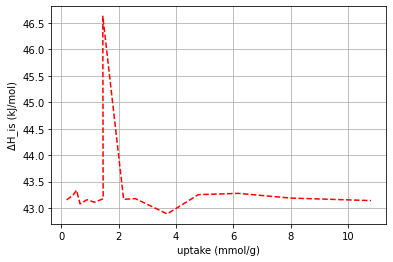

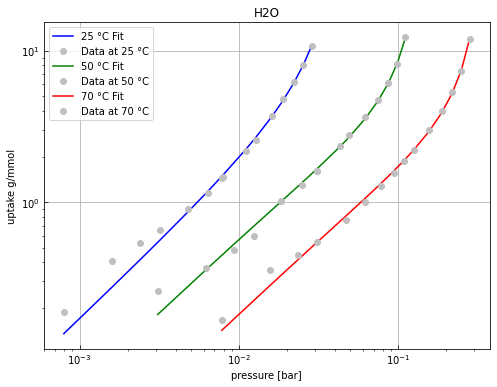

In [6]:
class TypeIII_fit:
    def __init__(self, df, compname, temps, keyPressures, keyUptakes, guess, logplot=False):
        self.df = df
        self.compname = compname
        self.keyPressures = keyPressures
        self.keyUptakes = keyUptakes
        self.temps = temps
        self.guess = guess
    
    def isotherm_fit(self, df, compname, temps, keyPressures, keyUptakes, guess, logplot=False):
        ##### setting up variables for fitting ####
        ###### allocating columns to lists ##### 

        #Importing data and allocating to variables
        y = []
        x = []
        for i in range(len(keyPressures)):
            x.append(df[keyPressures[i]].values)
            y.append(df[keyUptakes[i]].values)
            
        n_i = guess[0]  
        ka_i = guess[1]  
        ca_i = guess[2] 
        
        gmod = Model(GAB)
        

        c = []
        result = []
        for i in range(len(keyPressures)):
            pars = Parameters()
            pars.add('n', value=n_i, min=0)
            pars.add('ka', value=ka_i, min=0)
            pars.add('ca', value=ca_i, min=0)

            results = gmod.fit(y[i], pars, x=x[i])
            cee = [results.values['n'], results.values['ka'], results.values['ca']]
            
            
            
            result.append(results)
            c.append(cee)
            del results
            del pars
        
        #UNFORMATTER VARIABLES
        ka_ = [param[1] for param in c]
        ca_ = [param[2] for param in c]
        n_ = [param[0] for param in c]

        #FORMATTED VARIABLES
        n = [np.round(param[0], 3) for param in c]
        ka = [np.round(param[1], 3) for param in c]
        ca = [np.round(param[2], 3) for param in c]
        
        if len(temps) >= 3:
            T = np.array([1/(temp+273) for temp in self.temps])
            xT = []
            h = []
            for i in range(len(x[0])):
                xTT = []
                for p in x:
                    xTT.append(p[i])
                xT.append(xTT)
            for xi in xT:
                ln_x = [np.log(i) for i in xi]
                m, b, r2H, p, sterr = stats.linregress(T,ln_x)
                h.append(-0.001*m*r)
            plt.xlabel('uptake (mmol/g)')
            plt.ylabel('ΔH_is (kJ/mol)')
            plt.grid()
            plt.plot(y[0], h, '--', color = 'r')
            
            avgh = np.average(h)
            sterr = (1.96*np.std(h)/(len(h))**0.5)
            print("ΔH_is: " + str(round(avgh,2)) + " (∓ " + str(round(sterr, 2)) + ") kJ/mol. ")
            ln_ka = np.array([np.log(i) for i in ka_])
            ln_ca = np.array([np.log(i) for i in ca_])
            ln_n = np.array([np.log(i) for i in n_])
            mH, bH, rH, pH, sterrH = stats.linregress(T,ln_ka)
            mH2, bH2, rH2, pH2, sterrH2 = stats.linregress(T,ln_ca)
            mH3, bH3, rH3, pH3, sterrH3 = stats.linregress(T,ln_n)
            h1 = -0.001*mH*r
            h2 = -0.001*mH2*r
            h3 = -0.001*mH3*r

            print("_______________________________________________________________________")
            print("ΔH_ka: " + str(round(h1,2)) + " kJ/mol. " +
                  "R sq: " + str(round(rH, 4)))
            print("ΔH_ca: " + str(round(h2,2)) + " kJ/mol. " +
                  "R sq: " + str(abs(round(rH2, 4))) )
            print("ΔH_n: " + str(round(h3,2)) + " kJ/mol. " +
                  "R sq: " + str(abs(round(rH3, 4))) )

        # Checking r squared of fits
        r_sq = [r2(x[i], y[i], GAB, c[i]) for i in range(len(keyPressures))]
        se = [mse(x[i], y[i], GAB, c[i]) for i in range(len(keyPressures))]

        #Displaying results
        df_result = pd.DataFrame(list(zip(n, ka, ca, r_sq, se)), columns=['n (mmol/g)','ka (H2O activity coeff.)',
                                                                      'ca (GAB const.)','r_sq', 'mse'])

        display(pd.DataFrame(df_result))

        print(bold + "===============================================================================")
        print(bold + "===============================================================================")

        xaxis = 'pressure [bar]'
        yaxis = 'uptake g/mmol'

        ##### Plotting results #####
        plt.figure(figsize=(8, 6))
        plt.title(compname)
        if logplot == True:
            plt.xscale("log")
            plt.yscale("log")
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.tick_params(**tick_style)

        for i in range(len(keyPressures)):
            plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=temps[i]))
            plt.plot(x[i], y[i], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=temps[i]))

        plt.grid()
        plt.legend()


df1 = pd.read_csv('LewatitH₂O.csv')
keyPressures = ['Pressure [bar] 25', 'Pressure [bar] 50', 'Pressure [bar] 70']
keyUptakes = ['Loading [mmol/g] 25', 'Loading [mmol/g] 50', 'Loading [mmol/g] 70']
compname = 'H2O'
temps = [25, 50, 70]
guess = [1, 1, 1]

params = df1, compname, temps, keyPressures, keyUptakes, guess, True

H2O = TypeIII_fit(*params) # Calling Langmuir class to variable
h2o = H2O.isotherm_fit(*params)      # Calling method 'lang' for fitting

        

# Type IV/V Isotherm class

,n (layers),c,g,q (mmol/g),r_sq,mse
0,8.54449,6.251708,2734.323233,0.815386,0.998211,0.009621


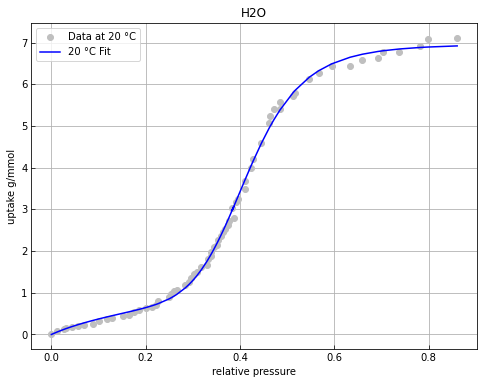

In [9]:
class TypeIV_V_fit:
    def __init__(self, df, compname, temps, isotherm, keyPressures, keyUptakes, guess, typeV=False, logplot=False):
        self.df = df
        self.compname = compname
        self.keyPressures = keyPressures
        self.keyUptakes = keyUptakes
        self.temps = temps
        self.guess = guess
        self.typeV = typeV
    
    def isotherm_fit(self, df, compname, temps, isotherm, keyPressures, keyUptakes, guess, typeV=False, logplot=False):
        ##### setting up variables for fitting ####
        ###### allocating columns to lists ##### 
        tempsK = [t+273 for t in temps]

        #Importing data and allocating to variables
        y = []
        x = []
        for i in range(len(keyPressures)):
            x.append(df[keyPressures[i]].values)
            y.append(df[keyUptakes[i]].values)
               
        gmod = Model(isotherm, nan_policy='omit')

        c = []
        result = []
        if isotherm == BET_ext1 or isotherm == BET_ext2:
            n_i = guess[0]
            c_i = guess[1]
            g_i = guess[2]
            q_i = guess[3]
            
            for i in range(len(keyPressures)):
                pars = Parameters()
                pars.add('n', value=n_i, min=0)
                
                if typeV == True:
                    pars.add('c', value=c_i, min=0)
                else:
                    pars.add('c', value=c_i, min=0, max=1)
                                    
                pars.add('g', value=g_i, min=0)
                pars.add('q', value=q_i, min=0)

                results = gmod.fit(y[i], pars, x=x[i])
                cee = [results.values['c'], results.values['n'], 
                       results.values['g'], results.values['q']]

                result.append(results)
                c.append(cee)
                del results
                del pars
                
            #FORMATTED VARIABLES
            n = [param[1] for param in c]
            c_par = [param[0] for param in c]
            g = [param[2] for param in c]
            q = [param[3] for param in c]
            #print(c[0])
            #print(result[0].best_values)
            
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results
            df_result = pd.DataFrame(list(zip(n, c_par, g, q, r_sq, se)), columns=['n (layers)','c','g',
                                                                               'q (mmol/g)','r_sq', 'mse'])

            display(pd.DataFrame(df_result))
                        
        elif isotherm == DoDo:
            ns_i = guess[0]
            kf_i = guess[1]
            nu_i = guess[2]
            ku_i = guess[3]
            m_i = guess[4]
            
            for i in range(len(keyPressures)):
                pars = Parameters()
                pars.add('ns', value=ns_i, min=0)
                pars.add('kf', value=kf_i, min=0)
                pars.add('nu', value=nu_i, min=0)
                pars.add('ku', value=ku_i, min=0)
                pars.add('m', value=m_i, min=0)

                results = gmod.fit(y[i], pars, x=x[i])
                cee = [results.values['ns'], results.values['kf'], results.values['nu'], results.values['ku'],
                      results.values['m']]

                result.append(results)
                c.append(cee)
                del results
                del pars
                
            #FORMATTED VARIABLES
            ns = [param[0] for param in c]
            kf = [param[1] for param in c]
            nu = [param[2] for param in c]
            ku = [param[3] for param in c]
            m = [param[4] for param in c]
            
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results
            df_result = pd.DataFrame(list(zip(ns, kf, nu, ku, m, r_sq, se)), 
                                     columns=['ns (mmol/g)','Kf'
                                              ,'Cμs(mmol/g)',
                                                'Kμ','n',
                                              'r_sq', 'mse'])

            display(pd.DataFrame(df_result))
            

        print(bold + "===============================================================================")
        print(bold + "===============================================================================")

        xaxis = 'relative pressure'
        yaxis = 'uptake g/mmol'

        ##### Plotting results #####
        plt.figure(figsize=(8, 6))
        plt.title(compname)
        if logplot == True:
            plt.xscale("log")
            plt.yscale("log")
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.tick_params(**tick_style)

        for i in range(len(keyPressures)):
            plt.plot(x[i], y[i], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=temps[i]))
            plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=temps[i]))
        #print(BET_ext1(x[0], *c[0]))
    
        plt.grid()
        plt.legend()

        
        
df = pd.read_csv('CMS.csv')

compname = 'H2O'
temps = [20]
isotherm = BET_ext2
keyUptakes = ['q1']
keyPressures = ['p 20']      
guess = [10, 100, 1000, 3]        
pars = df, compname, temps, isotherm, keyPressures, keyUptakes, guess, True, False    
Test = TypeIV_V_fit(*pars)
test = Test.isotherm_fit(*pars)

         This may affect accuracy of results.
         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).


,Temperature (oC),Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,10,0.000881,0.246877,3,0.99519
1,40,0.005610,0.035290,3,0.99995
2,100,0.089381,0.022757,7,0.99987


,Temperature (oC),Qmax (mmol/g),b (1/bar),R squared,MSE
0,10,2108.994,2.479e-04,0.313690,6.653334
1,40,1426.355,4.607e-04,0.427130,5.553609
2,100,148.708,7.725e-03,0.696733,2.939979


_______________________________________________________________________
Heat of adsorption: 34.52 kJ/mol. 
R sq of Van't Hoff: -0.9724
List for intial guess values to feed into the temperature dependent Langmuir model:
[2108.993623143068, 0.0002479356596727378, 34.51937970785191, 434.017235893284]


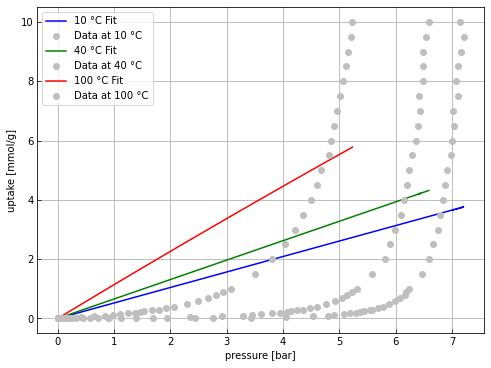

In [5]:
class TypeI_fit:
    def __init__(self, df, temps, name, isotherm, keyPressures, keyUptakes, guess, logplot=False, fix=True, meth='leastsq',
                tol = 0.9999):

        self.df = df                 #Dataframe with uptake vs. pressure data
        self.temps = temps           #Temp in deg C
        self.meth = meth             #Optional to choose mathematical fitting method in lmfit (default is leastsq)
        self.name = name             #Name of component
        self.isotherm = isotherm     #Form of langmuir to fit
        
        self.keyPressures = keyPressures #names of the column headers for pressure and uptakes
        self.keyUptakes = keyUptakes    #
        
        self.guess = guess
    
        
        
        self.fix = fix
        self.tol = tol
   
    def lang(self, df, temps, name, isotherm, keyPressures, keyUptakes,
             guess, logplot=False, fix=True, meth='leastsq', tol = 0.9999): 

        ##### setting up variables for fitting ####
        ###### allocating columns to lists ##### 
            
        #Importing data and allocating to variables
        
        #Importing data and allocating to variables
        sets = []
        pres = []         
        for i in range(len(keyPressures)):
            xi = np.insert(np.array(df[keyPressures[i]].values), 0, 0)
            yi = np.insert(np.array(df[keyUptakes[i]].values), 0, 0)
            sets.append(xi)
            pres.append(yi)
            del xi
            del yi
        x = []
        y = []
        #These conditions prepare the data for the required form wrt to the chosen model
        if isotherm == linear_langmuir1:
            for i in range(len(keyPressures)):
                x.append([1 / x for x in pres[i]])
                y.append([1 / y for y in sets[i]])

            xaxis = "1/pressure [1/bar]"
            yaxis = "1/uptake [g/mmol]"
        elif isotherm == linear_langmuir2:
            for i in range(len(keyPressures)):
                x.append(pres[i])
                y.append([p / q for (p, q) in zip(pres[i], sets[i])])
                
            xaxis = "pressure [bar]"
            yaxis = "pressure/uptake [(bar mmol)/g]"
        elif isotherm == single_langmuir or isotherm == deltaH_langmuir:
            for i in range(len(keyPressures)):
                x.append(pres[i])
                y.append(sets[i])
                
            xaxis = "pressure [bar]"
            yaxis = "uptake [mmol/g]"
        elif isotherm == mdr or isotherm == mdr_temp:
            for i in range(len(keyPressures)):
                pressure = pres[i]
                x.append(np.array([x / pressure[-1] for x in pres[i]]))
                y.append(sets[i])
                del pressure
            xaxis = "relative pressure (P/P)"
            yaxis = "uptake [mmol/g]"

        
        #This section finds the henry region of the datasets
        henry_constants = []
        henry_limits = []
        henry_rsq = []
        rsq_lst = []
        hen_lst = []
        henry_len = []
        errHen = []
        i = 0

        for dataset in sets:
            rsq = 1
            x_ = pres[i]
            x_henry = [x_[0], x_[1], x_[2]] #Starting with a minimum of two datapoints
            counter = 3 
            rsq_ilst = []
            hen_ilst = []
            #This loop adds data points while the points correspond to a henry fit with an R^2 of above 0.9995
            while rsq > 0 and counter < len(x_): 
                x_henry.append(x_[counter])
                y_henry = dataset[:len(x_henry)]

                hen= y_henry[-1] / x_henry[-1]
                rsq = round(r2hen(x_henry, y_henry, henry, hen),5) #r squared calc.
                rsq_ilst.append(rsq)
                hen_ilst.append(hen)
                counter += 1
            rsq_lst.append(rsq_ilst) 
            hen_lst.append(hen_ilst)
            #plt.figure()


            abtol = []
            itol = []
            i2 = 0
            for rsq in rsq_ilst:
                if rsq > tol:
                    abtol.append(rsq)
                    itol.append(i2)
                i2 += 1
            if abtol == []:
                maxrsq = max(rsq_ilst)
                rsqidx = rsq_ilst.index(maxrsq)
            else:
                rsqfin = min(abtol)
                minidx = abtol.index(rsqfin)
                rsqidx = itol[minidx]
                maxrsq = rsq_ilst[rsqidx]

            henidx = rsqidx + 2

            henry_len.append(henidx+1)
            #Saving Henry region parameters to later display
            henry_constants.append(hen_ilst[rsqidx])
            henry_limits.append(x_henry[henidx])
            henry_rsq.append(rsq_ilst[rsqidx])
            # sometimes data may not have a good henry region fit, which could abort the above while loop after the first
            # iteration. This piece of code warns the user of this
            if henidx+1 < 4:
                errHen.append(str(i+1))
            i += 1
        if errHen != []:
            print(unbold + 'WARNING: Henry region for dataset(s) ' + ', '.join(errHen) + ' were found to be made up of less than 4 points.')
            print('         This may affect accuracy of results.')
            print('         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).')  

        #Creating dataframe for henry constants
        df_henry = pd.DataFrame(list(zip(self.temps, henry_constants, henry_limits, henry_len, henry_rsq)), 
                                columns=['Temperature (oC)','Henry constant (mmol/(bar.g))',
                                        'Upper limit (bar)','datapoints', 'R squared'])
        display(pd.DataFrame(df_henry))
        
        #lmfit
        gmod = Model(isotherm, nan_policy='omit') #second argument omits the NaN error that can sometimes cause issues
        
        # Here the parameters are created for the isotherm for fitting
        # The user can choose whether or not to fix qmax to a specific value
        # When qsat is fixed, lmfit will only fit for b with qsat as a constant
        # This also fixes q*b to the henry constant for the corresponding temp
        if isotherm != mdr:
            q_init=guess[0]
            b_init=guess[1]
            if isotherm == deltaH_langmuir:
                h_init=guess[2]
                b0_init=guess[3]
        
        tempsK = [t+273 for t in temps]
        #################################        FITTING          ################################################
        if isotherm == linear_langmuir1 or isotherm == linear_langmuir2 or isotherm == single_langmuir:
            if fix == True:  
                print("Constraint 1: q sat = q_init for all temp")
                print("Constraint 2: qsat*b = Henry constant for all temp")
                c = []
                result = []

                for i in range(len(keyPressures)):
                    pars = Parameters()
                    pars.add('q', value=q_init, min=q_init, max=q_init+0.001)
                    #Creating intermediate parameter delta that will fix KH = b*q
                    pars.add('delta', value=henry_constants[i], vary=False) 
                    pars.add('b', expr='delta/q') #KH = b*q
                    
                    results = gmod.fit(y[i], pars, x=x[i], method=meth)
                    cee = [results.values['q'], results.values['b']] 
                    result.append(results)
                    c.append(cee)
                    del results
                    del pars
                
            else: 
                #If constraints are not set, a normal fitting procedure is carried out
                c = []
                result = []

                for i in range(len(keyPressures)):
                    pars = Parameters()
                    pars.add('q', value=q_init, min=0)
                    pars.add('b', value=b_init, min=0)
                    
                    results = gmod.fit(y[i], pars, x=x[i], method=meth)
                    cee = [results.values['q'], results.values['b']] 
                    result.append(results)
                    c.append(cee)
                    del results
                    del pars
                
            #allocating variables and creating dataframe
            #UNFORMATTED VARIABLES
            q_ = [param[0] for param in c]
            b_ = [param[1] for param in c]

            #FORMATTED VARIABLES
            qmax = [np.round(param[0], 3) for param in c]
            b = ["{:.3e}".format(param[1]) for param in c]

            # Checking r squared of fits
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            

            df_result = pd.DataFrame(list(zip(self.temps, qmax, b, r_sq, se)), columns=['Temperature (oC)','Qmax (mmol/g)',
                                                                                  'b (1/bar)', 'R squared', 'MSE'])
            #displaying dataframe
            display(pd.DataFrame(df_result))
            
            #calculating heat of adsorption
            T = np.array([1/(temp+273) for temp in self.temps])
            ln_b = np.array([np.log(i) for i in b_])
            mH, bH, rH, pH, sterrH = stats.linregress(T,ln_b)
            h = -0.001*mH*r
            
            print("_______________________________________________________________________")
            print("Heat of adsorption: " + str(round(h,2)) + " kJ/mol. \n" +
                  "R sq of Van't Hoff: " + str(round(rH, 4)))
            
            #b0 is also calculated and displayed to the user.
            #This can be then fed back into the class with delta H to fit to the van't Hoff form of langmuir
            b0 = np.exp(bH)
            print("List for intial guess values to feed into the temperature dependent Langmuir model:")
            print([q_[0], b_[0], h, b0])
            
        elif isotherm == deltaH_langmuir:
            #Here only qmax is fixed, not henry
            
            c = []
            result = []

            for i in range(len(keyPressures)):                
                pars = Parameters()
                pars.add('t', value=tempsK[0], vary = False)
                pars.add('q', value=q_init, min=q_init, max=q_init+0.001)
                pars.add('h', value=h_init*1000)
                pars.add('b0', value=b0_init, min=0)   

                results = gmod.fit(y[i], pars, x=x[i], method=meth)
                cee = [results.values['t'], results.values['q'], results.values['b0'], results.values['h']] 
                result.append(results)
                c.append(cee)
                del results
                del pars
            
            #FORMATTED VARIABLES
            qmax = [np.round(param[1], 3) for param in c]
            b0 = ["{:.3e}".format(param[2]) for param in c]
            h = [np.round(param[3], 3) for param in c]
            
            
            #r squared calc.
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results as dataframe
            df_result = pd.DataFrame(list(zip(self.temps, qmax, b0, h, r_sq)), columns=['Temperature (oC)','Qmax (mmol/g)',
                                                                                  'b0 (1/bar)','H (J/mol)', 'R squared'])
            display(pd.DataFrame(df_result))
        elif isotherm == mdr_temp:
            c = []
            result = []
            n0_init = guess[0]
            n1_init = guess[1]
            a_init = guess[2]
            b_init = guess[3]
            e_init = guess[4]
                
            for i in range(len(keyPressures)):
                pars = Parameters()
                pars.add('t', value=tempsK[0], vary = False)
                pars.add('n0', value=n0_init, min=0)
                pars.add('n1', value=n1_init, min=0)
                pars.add('a', value=a_init, min=0)
                pars.add('b', value=b_init, min=0) 
                pars.add('e', value=e_init)
                

                results = gmod.fit(y[i], pars, x=x[i], method=meth)
                cee = [results.values['t'], results.values['n0'], results.values['n1'], results.values['a'],
                      results.values['b'], results.values['e']] 
                result.append(results)
                c.append(cee)
                del results
                del pars
            
            #FORMATTED VARIABLES
            n0 = [param[1] for param in c]
            n1 = [param[2] for param in c]
            a = [param[3] for param in c]
            b = [param[4] for param in c]
            e = [param[5] for param in c]

            #r squared calc.
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results as dataframe
            df_result = pd.DataFrame(list(zip(self.temps, n0, n1, a, b, e, r_sq, se)), 
                                     columns=['Temperature (oC)','n0 (mmol/g)', 'n1 (mmol/g)','a', 'b','e (J/mol)','R squared', 'MSE'])
            display(pd.DataFrame(df_result))
            #print(c[0])
            
        elif isotherm == mdr:
            c = []
            result = []
            q_init = guess[0]
            v1_init = guess[1]
            a_init = guess[2]
            k_init = guess[3]
                
            for i in range(len(keyPressures)):
                pars = Parameters()                
                if fix == True:
                    pars.add('n0', value=q_init, min=0)
                    pars.add('delta', value=henry_constants[i], vary=False) 
                    pars.add('n1', expr='delta/n0') #KH = n0*n1
                else:
                    pars.add('n0', value=q_init, min=0)
                    pars.add('n1', value=v1_init, min=0)                
                pars.add('a', value=a_init, min=0)
                pars.add('c', value=k_init, min=0) 

                results = gmod.fit(y[i], pars, x=x[i], method=meth)
                cee = [results.values['n0'], results.values['n1'], results.values['a'],
                      results.values['c']] 
                result.append(results)
                c.append(cee)
                del results
                del pars
            
            #FORMATTED VARIABLES
            q = [param[0] for param in c]
            v1 = [param[1] for param in c]
            a = [param[2] for param in c]
            k = [param[3] for param in c]
            
            if len(temps) >= 3:
                T = [1/t for t in temps]
                ln_k = np.array([np.log(i) for i in k])
                mH, bH, rH, pH, sterrH = stats.linregress(T,ln_k)
                h1 = -0.001*mH*r

                print("_______________________________________________________________________")
                print("ΔH_k: " + str(round(h1,2)) + " kJ/mol. " +
                      "R sq: " + str(round(rH, 4)))
        
            #r squared calc.
            r_sq = [r2(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            se = [mse(x[i], y[i], isotherm, c[i]) for i in range(len(keyPressures))]
            
            #Displaying results as dataframe
            df_result = pd.DataFrame(list(zip(self.temps, q, v1, a, k, r_sq, se)), 
                                     columns=['Temperature (oC)','q (mmol/g)', 'v1 (mmol/g)','a', 'k', 'R squared', 'MSE'])
            display(pd.DataFrame(df_result))
            print("Guess values for pasting:")
            print(c[0])
            
                  
        p=np.linspace(0, 10, 301)

        ##### Plotting results #####
        plt.figure(figsize=(8, 6))
        #plt.title()
        if logplot == True:
            plt.xscale("log")
            plt.yscale("log")
        plt.xlabel(xaxis)
        plt.ylabel(yaxis)
        plt.tick_params(**tick_style)

        for i in range(len(keyPressures)):
            plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=temps[i]))
            plt.plot(x[i], y[i], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=temps[i]))

        plt.grid()
        plt.legend()
        plt.show()

df1 = pd.read_csv('Computational Data (EPFL) CO2.csv')
#df = pd.read_csv('Computational Data (EPFL) N2.csv')
#df = pd.read_csv('UIO66CO2.csv')
compname = 'N2'
temps = [10, 40, 100]
meth = 'tnc'
keyUptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']
keyPressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']
guess = [1, 1, 1, 1]
isotherm = single_langmuir
#keyPressures = ['Pressure1', 'Pressure2', 'Pressure3']
#keyUptakes = ['Uptake1', 'Uptake2', 'Uptake3']
tolerance = 0.9999 # set minimum r squared value

pars = df1, temps, compname, isotherm, keyPressures, keyUptakes, guess, False, False, meth
langmuir = TypeI_fit(*pars)
langmuir.lang(*pars)

               
        

# Henry's Law Isotherm

,Temperature (oC),Henry constant (mmol/(bar.g)),Upper limit (bar),datapoints,R squared
0,10,0.053941,43.82881,26,0.73365
1,40,0.214740,0.72452,5,0.27009
2,100,0.028041,43.82881,26,0.82172


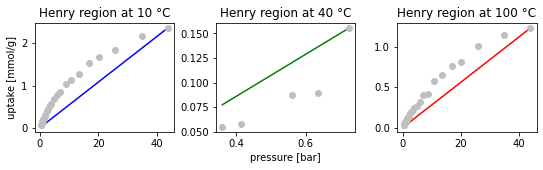

In [38]:
class Henry:
    def __init__(self, df, compname, keyPressures, keyUptakes, temps, tol=0.9995, logplot=False, zero=False):
        self.df = df
        self.compname = compname
        self.keyPressures = keyPressures
        self.keyUptakes = keyUptakes
        self.temps = temps
        self.tol = tol
        self.zero = zero
        
    def isotherm_fit(self, df, compname, keyPressures, keyUptakes, temps, tol=0.9995, logplot=False, zero=False):
        #Importing data and allocating to variables
        
        #Importing data and allocating to variables
        sets = []
        pres = []
        for i in range(len(keyPressures)):
            if zero == True:
                x = np.insert(np.array(df[keyPressures[i]].values), 0, 0)
                y = np.insert(np.array(df[keyUptakes[i]].values), 0, 0)
                pres.append(x)
                sets.append(y)
                del x
                del y
            else:
                pres.append(df[keyPressures[i]].values)
                sets.append(df[keyUptakes[i]].values)

                

        
        henry_constants = []
        henry_limits = []
        henry_rsq = []
        rsq_lst = []
        hen_lst = []
        hen_len = []
        i = 0
        
        plt.figure(figsize=(9, 2))
        for dataset in sets:
            rsq = 1
            x_ = pres[i]
            if zero == True:
                x_henry = [x_[0], x_[1], x_[2]] #Starting with a minimum of two datapoints
                counter = 3 
            else:
                x_henry = [x_[0], x_[1]]
                counter = 2
            rsq_ilst = []
            hen_ilst = []
            #This loop adds data points while the points correspond to a henry fit with an R^2 of above 0.9995
            if tol == 0:
                while counter < len(x_): 
                    x_henry.append(x_[counter])
                    y_henry = dataset[:len(x_henry)]

                    hen= y_henry[-1] / x_henry[-1]
                    rsq = round(r2hen(x_henry, y_henry, henry, hen),5) #r squared calc.
                    rsq_ilst.append(rsq)
                    hen_ilst.append(hen)
                    counter += 1
            else:
                while rsq > 0 and counter < len(x_): 
                    x_henry.append(x_[counter])
                    y_henry = dataset[:len(x_henry)]

                    hen= y_henry[-1] / x_henry[-1]
                    rsq = round(r2hen(x_henry, y_henry, henry, hen),5) #r squared calc.
                    rsq_ilst.append(rsq)
                    hen_ilst.append(hen)
                    counter += 1
            rsq_lst.append(rsq_ilst) 
            hen_lst.append(hen_ilst)
            #plt.figure()
        
            abtol = []
            itol = []
            i2 = 0
            for rsq in rsq_ilst:
                if rsq > tol:
                    abtol.append(rsq)
                    itol.append(i2)
                i2 += 1
            if abtol == []:
                maxrsq = max(rsq_ilst)
                rsqidx = rsq_ilst.index(maxrsq)
            else:
                rsqfin = min(abtol)
                minidx = abtol.index(rsqfin)
                rsqidx = itol[minidx]
                maxrsq = rsq_ilst[rsqidx]
            
            henidx = rsqidx + 2
            
            hen_len.append(henidx+1)
            


            y_henryFit = [hen_ilst[rsqidx]*x for x in x_henry[:henidx+1]]
            
        
            #plt.plot(x_henry, y_henry, 'o', label=str(temps[i])+' C')
            #plt.plot(x_henry, y_henryFit, 'r--')
            #plt.title()


            plt.subplot(1, 3, i+1)
            plt.subplots_adjust(wspace = 0.3, hspace =0.2)

            plt.plot(x_henry[:henidx+1], y_henryFit, '-', color = colours[i], 
                     label="{temps} °C Fit".format(temps=temps[i]))
            plt.plot(x_henry[:henidx+1], y_henry[:henidx+1], 'ko', color = '0.75', 
                     label="Data at {temps} °C".format(temps=temps[i]))
            if logplot == True:
                plt.xscale("log")
                plt.yscale("log")
            plt.title('Henry region at ' + str(temps[i]) + ' °C')
            if i == 0:
                plt.ylabel('uptake [mmol/g]')
            if i == 1:
                plt.xlabel('pressure [bar]')
            #plt.tick_params(**tick_style)
            
            #Saving Henry region parameters to later display
            henry_constants.append(hen_ilst[rsqidx])
            henry_limits.append(x_henry[henidx])
            henry_rsq.append(rsq_ilst[rsqidx])
            
            i+=1
        
        
        #Creating dataframe for henry constants
        df_henry = pd.DataFrame(list(zip(self.temps, henry_constants, henry_limits, hen_len, henry_rsq)), 
                                columns=['Temperature (oC)','Henry constant (mmol/(bar.g))',
                                        'Upper limit (bar)', 'datapoints', 'R squared'])
        display(pd.DataFrame(df_henry))    
        
    
        
#df1 = pd.read_csv('Computational Data (EPFL) CO2.csv')
#df = pd.read_csv('Computational Data (EPFL) N2.csv')
df = pd.read_csv('UIO66N2.csv')
compname = 'N2'
temps = [10, 40, 100]
#keyUptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']
#keyPressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']

keyPressures = ['Pressure1', 'Pressure2', 'Pressure3']
keyUptakes = ['Uptake1', 'Uptake2', 'Uptake3']
tolerance = 0 # set minimum r squared value
pars = df, compname, keyPressures, keyUptakes, temps, tolerance, False, False
henry1 = Henry(*pars)
henry1.isotherm_fit(*pars)

        
        

# Farhamini et al. (2018) procedure for fitting Dual Site Langmuir Isotherm model

In [ ]:
###############################################################################################


#The below code is a class that runs the Farhamini procedure of the thermodynamically consistent dual site Langmuir 
#Fitting. It consists of an inner class which can run three different steps, each with two variations whos procedure
#varies depending on the component and an outer class, which controlls which runs the three steps sequentially.


###############################################################################################

In [31]:
class DSL_fit:
    def __init__(self, temps, guess, keyPressures, keyUptakes, compnames, df_list, logplot=False, tol=0.9999,
                 meth='leastsq', fix=None, yA=None):
        
        #These are required for both the inner class and outer class
        self.temps = temps
        self.meth = meth
        
        #initial guess values for dsl fitting
        self.guess = guess

        self.keyPressures = keyPressures
        self.keyUptakes = keyUptakes
        self.compname = compnames
        
        #A list of dataframes is inputted here, meaning that the user can fit to any number of components simultaneously
        #Using the DSL procedure
        self.df_list = df_list 
        #self.individ_sheet = individ_sheet
        self.fix = fix
        self.yA = yA
        self.tol = tol

        
    
    def fit_isotherm(self, temps, guess, keyPressures, keyUptakes, compnames, df_list, logplot=False, tol=0.9999,
                     meth='leastsq', fix=None, yA=None):
        
        class DSL:
            def __init__(self, df, temps, meth, q1_init, q2_init, b1_init, b2_init, keyPressures, keyUptakes, compname,
                         logplot=False, tol=0.9999, step=None, step1=None, step3=None, comp2=False):

                self.df = df         #Dataframe with uptake vs. pressure data
                self.temps = temps   #Temp in deg C
                self.meth = meth     #Optional to choose mathematical fitting method in lmfit (default is leastsq)

                #initial guess values for dsl fitting
                self.q1_init = q1_init
                self.q2_init = q2_init
                self.b1_init = b1_init
                self.b2_init = b2_init

                self.keyPressures = keyPressures #names of the column headers for pressure and uptakes
                self.keyUptakes = keyUptakes
                self.compname = compname

                self.step = step

                self.step1 = step1
                self.step3 = step3

                self.comp2 = comp2

            def dslfit(self, df, temps, meth, q1_init, q2_init, b1_init, b2_init, keyPressures, keyUptakes, compname,
                       logplot=False, tol=0.9999, step=None, step1=None, step3=None, comp2=None):

                ##### setting up variables for fitting ####
                ###### allocating columns to lists ##### 
        
                #Importing data and allocating to variables
                y = []
                x = []
                for i in range(len(keyPressures)):
                    xi = np.insert(np.array(df[keyPressures[i]].values), 0, 0)
                    yi = np.insert(np.array(df[keyUptakes[i]].values), 0, 0)
                    x.append(xi)
                    y.append(yi)
                    del xi
                    del yi
                

            ########################################################
                
                #This section finds the henry region of the datasets
                henry_constants = []
                henry_limits = []
                henry_rsq = []
                rsq_lst = []
                hen_lst = []
                henry_len = []
                errHen = []
                i = 0

                for dataset in y:
                    rsq = 1
                    pres = x[i]
                    x_henry = [pres[0], pres[1], pres[2]] #Starting with a minimum of two datapoints
                    counter = 3
                    rsq_ilst = []
                    hen_ilst = []
                    #This loop adds data points while the points correspond to a henry fit with an R^2 of above 0.9995
                    while rsq > 0 and counter < len(pres): 
                        x_henry.append(pres[counter])
                        y_henry = dataset[:len(x_henry)]

                        hen= y_henry[-1] / x_henry[-1]
                        rsq = round(r2hen(x_henry, y_henry, henry, hen),5) #r squared calc.
                        rsq_ilst.append(rsq)
                        hen_ilst.append(hen)
                        counter += 1
                    rsq_lst.append(rsq_ilst) 
                    hen_lst.append(hen_ilst)
                    #plt.figure()


                    abtol = []
                    itol = []
                    i2 = 0
                    for rsq in rsq_ilst:
                        if rsq > tol:
                            abtol.append(rsq)
                            itol.append(i2)
                        i2 += 1
                    if abtol == []:
                        maxrsq = max(rsq_ilst)
                        rsqidx = rsq_ilst.index(maxrsq)
                    else:
                        rsqfin = min(abtol)
                        minidx = abtol.index(rsqfin)
                        rsqidx = itol[minidx]
                        maxrsq = rsq_ilst[rsqidx]

                    henidx = rsqidx + 2

                    henry_len.append(henidx+1)
                    #Saving Henry region parameters to later display
                    henry_constants.append(hen_ilst[rsqidx])
                    henry_limits.append(x_henry[henidx])
                    henry_rsq.append(rsq_ilst[rsqidx])
                    # sometimes data may not have a good henry region fit, which could abort the above while loop after the first
                    # iteration. This piece of code warns the user of this
                    if henidx+1 < 4:
                        errHen.append(str(i+1))
                    i += 1
                if step == 3 and errHen != []:
                    print(unbold + 'WARNING: Henry region for dataset(s) ' + ', '.join(errHen) + ' were found to be made up of less than 4 points.')
                    print('         This may affect accuracy of results.')
                    print('         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).')  
                                   
                if step == 4:
                    gmod = Model(dsl)
                    c = []
                    result = []
                    for i in range(len(keyPressures)):
                        pars = Parameters()
                        pars.add('q1', value=q1_init, min=0)
                        pars.add('q2', value=q2_init, min=0)
                        pars.add('b2', value=b2_init, min=0)
                        pars.add('b1', value=b1_init, min=0) #KH = b*q

                        results = gmod.fit(y[i], pars, x=x[i], method=meth)
                        cee = [results.values['q1'], results.values['q2'], 
                                  results.values['b1'], results.values['b2']]
                        c.append(cee)
                        result.append(results)

                        del results
                        del pars

                            
                    #allocating variables
                    qmax1 = [param[0] for param in c]
                    qmax2 = [param[1] for param in c]
                    b1 = [param[2] for param in c]
                    b2 = [param[3] for param in c]
                    qtot = [param[0] + param[1] for param in c]
                    t = temps

                    
                    # Checking r squared of fits
                    r_sq = [r2(x[i], y[i], dsl, c[i]) for i in range(len(keyPressures))]
                    se = [mse(x[i], y[i], dsl, c[i]) for i in range(len(keyPressures))]
                    
                    #Displaying results
                    df_result = pd.DataFrame(list(zip(t, qmax1, qmax2, b1, b2, r_sq, se)), 
                                    columns=['Temp(K)','qmax1 (mmol/g)',
                                            'qmax2 (mmol/g)','b1 (1/bar)', 'b2 (1/bar)' ,'R sq', 'mse'])

                    display(pd.DataFrame(df_result))
                    
                    print(bold + "===============================================================================")
                    print(bold + "===============================================================================")

                    xaxis = 'pressure [bar]'
                    yaxis = 'uptake mmol/g'

                    ##### Plotting results #####
                    plt.figure(figsize=(8, 6))
                    plt.title(compname)
                    if logplot == True:
                        plt.xscale("log")
                        plt.yscale("log")
                    plt.xlabel(xaxis)
                    plt.ylabel(yaxis)
                    plt.tick_params(**tick_style)
                    
                    for i in range(len(keyPressures)):
                        plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                                 label="{temps} °C Fit".format(temps=temps[i]))
                        plt.plot(x[i], y[i], 'ko', color = '0.75', 
                                 label="Data at {temps} °C".format(temps=temps[i]))

                    plt.grid()
                    plt.legend()
                
                # Here is the step procedure mentioned above
                # The outer class controls which step is being carried out
                # The first step is to find the initial q1, q2, b1, b2 values with the henry constraint set
                if step == 1:
                    gmod = Model(dsl)
                    pars1 = Parameters()
                    pars1.add('q1', value=q1_init, min=0)
                    pars1.add('q2', value=q2_init, min=0)
                    pars1.add('b2', value=b2_init)
                    pars1.add('delta', value=henry_constants[0], vary=False)
                    pars1.add('b1', expr='(delta-q2*b2)/q1') #KH = b1*q1 + b2*q2

                    result1 = gmod.fit(y[0], pars1, x=x[0], method=meth)

                    c1 = [result1.values['q1'], result1.values['q2'], result1.values['b1'], result1.values['b2']]
                    return c1[0], c1[1] 
                    
                    # This ends the function within the inner class and returns the qmax values to
                    # be used in step 2
                if step == 2: 
                    # This step calculates b1, b2 parameters for the remaining datasets with constraints:
                    # qmax fixed for all fittings from previous steps
                    # henry region constraint

                    q1fix = step1[0]
                    q2fix = step1[1]
                    ############################### FITTING ##########################################
                    if comp2 == True:
                        #Depending on whether the package is fitting for the most adsorbed componennt or the
                        #remaining components, the fitting procedure is different. In the methodology used,
                        #The most adsorbed component is fitted to DSL but the remaining components are 
                        #fitted to essentially the single langmuir isotherm
                        gmod = Model(single_langmuir)
                        qtot = q1fix + q2fix
                        
                        
                        c = []
                        for i in range(len(keyPressures)):
                            pars = Parameters()
                            pars.add('q', value=qtot, min=qtot, max=qtot+0.001)
                            pars.add('delta', value=henry_constants[i], vary=False)
                            pars.add('b', expr='delta/q')
                            
                            results = gmod.fit(y[i], pars, x=x[i], method=meth)
                            cee = [q1fix, q2fix, results.values['b'], results.values['b']]
                            c.append(cee)
                            
                            del results
                            del pars

                    else:
                        gmod = Model(dsl)
                        c = []
                        for i in range(len(keyPressures)):
                            pars = Parameters()
                            pars.add('q1', value=q1fix, min=q1fix, max=q1fix+0.001)
                            pars.add('q2', value=q2fix, min=q2fix, max=q2fix+0.001)
                            pars.add('b2', value=b2_init, min=0)
                            pars.add('delta', value=henry_constants[i], vary=False)
                            pars.add('b1', expr='(delta-q2*b2)/q1', min=0) #KH = b*q
                            
                            results = gmod.fit(y[i], pars, x=x[i], method=meth)
                            cee = [results.values['q1'], results.values['q2'], 
                                      results.values['b1'], results.values['b2']]
                            c.append(cee)
                            
                            del results
                            del pars

                            
                    #allocating variables
                    qmax1 = [param[0] for param in c]
                    qmax2 = [param[1] for param in c]
                    b1 = [param[2] for param in c]
                    b2 = [param[3] for param in c]
                    qtot = [param[0] + param[1] for param in c]
                    
                    #Finding heat of adsorption for both sites
                    T = np.array([1/(temp+273) for temp in self.temps])
                    ln_b1 = np.array([np.log(i) for i in b1])
                    ln_b2 = np.array([np.log(i) for i in b2])
                    mH1, bH1, rH1, pH1, sterrH1 = stats.linregress(T,ln_b1)
                    mH2, bH2, rH2, pH2, sterrH2 = stats.linregress(T,ln_b2)
                    

                    h = [-0.001*mH1*r, -0.001*mH2*r]
                    b0 = [np.exp(bH1), np.exp(bH2)]
                    
                    # The package returns these sets of parameters to be used as initial guesses for the final step
                    return qmax1[0], qmax2[0], h, b0
                if step == 3:

                    #Creating dataframe for henry constants
                    #We can now display henry region results
                    print(bold + "\nHenry regions found...")
                    
                    df_henry = pd.DataFrame(list(zip(self.temps, henry_constants, henry_limits, henry_len, henry_rsq)), 
                                            columns=['Temperature (oC)','Henry constant (mmol/(bar.g))',
                                                    'Upper limit (bar)','Datapoints', 'R squared'])
                    display(pd.DataFrame(df_henry))
                    
                    tempsK = [t+273 for t in temps]

                    #unpacking tuples
                    q1_in = step3[0]
                    q2_in = step3[1]
                    h_in = step3[2]
                    b0_in = step3[3]
                    
                    # We can now fit to the van't Hoff form of DSL with the initial guess values
                    # obtained through step 2
                    
                    if comp2 == True:
                        # Again, we fit to the single langmuir form when the least adsorbed species is used   
                        gmod = Model(deltaH_langmuir)
                        qtot = q1_in + q2_in
                        c = []
                        result = []
                        for i in range(len(keyPressures)):
                            pars = Parameters()
                            pars.add('t', value=tempsK[i], vary = False)
                            pars.add('q', value=qtot, min=qtot, max=qtot+0.001)
                            pars.add('h', value=h_in[0]*1000)
                            pars.add('b0', value=b0_in[0], min=0)
                            
                            results = gmod.fit(y[i], pars, x=x[i], method=meth)
                            result.append(results)
                            
                            c.append([results.values['t'], q1_in, q2_in, results.values['h'],
                                      results.values['h'], results.values['b0'], results.values['b0']])
                            
                            del results
                            del pars

                            
                    else:
                        gmod = Model(dsl_h) #DSL                            
                        c = []
                        result = []
                        for i in range(len(keyPressures)):
                            pars = Parameters()
                            pars.add('t', value=tempsK[i], vary = False)
                            pars.add('q1', value=q1_in, min=q1_in, max=q1_in+0.001)
                            pars.add('q2', value=q2_in, min=q2_in, max=q2_in+0.001)
                            pars.add('h1', value=h_in[0]*1000)
                            pars.add('h2', value=h_in[1]*1000)
                            pars.add('b01', value=b0_in[0], min=0)
                            pars.add('b02', value=b0_in[1], min=0)                

                            results = gmod.fit(y[i], pars, x=x[i], method=meth)
                            result.append(results)
                            c.append([results.values['t'], results.values['q1'], results.values['q2'], results.values['h1'], 
                                      results.values['h2'], results.values['b01'], results.values['b02']])
                            
                            del results
                            del pars
                            
                            
                    print(bold + "\nParameters found...")

                    #allocating variables, formatting and creating dataframe
                    
                    t = [param[0] for param in c]
                    
                    #UNFORMATTED VARIABLES
                    q1 = [param[1] for param in c]
                    q2 = [param[2] for param in c]
                    h_1 = [param[3] for param in c]
                    h_2 = [param[4] for param in c]
                    b_01 = [param[5] for param in c]
                    b_02 = [param[6] for param in c]
                    
                    #FORMATTED VARIABLES
                    qmax1 = [np.round(param[1], 3) for param in c]
                    qmax2 = [np.round(param[2], 3) for param in c]
                    h1 = [np.round(param[3], 3) for param in c]
                    h2 = [np.round(param[4], 3) for param in c]
                    b01 = ["{:.3e}".format(param[5]) for param in c]
                    b02 = ["{:.3e}".format(param[6]) for param in c]
                    
                    # Checking r squared of fits
                    r_sq = [r2(x[i], y[i], dsl_h, c[i]) for i in range(len(keyPressures))]
                    se = [mse(x[i], y[i], dsl_h, c[i]) for i in range(len(keyPressures))]
                    
                    #Displaying results
                    df_result = pd.DataFrame(list(zip(t, qmax1, qmax2, h1, h2, b01, b02, r_sq, se)), 
                                    columns=['Temp(K)','qmax1 (mmol/g)',
                                            'qmax2 (mmol/g)','h1 (J/mol)', 'h2 (J/mol)', 'b01 (1/bar)', 'b02 (1/bar)','R sq', 'mse'])

                    display(pd.DataFrame(df_result))
                    
                    print(bold + "===============================================================================")
                    print(bold + "===============================================================================")

                    xaxis = 'pressure [bar]'
                    yaxis = 'uptake mmol/g'

                    ##### Plotting results #####
                    plt.figure(figsize=(8, 6))
                    plt.title(compname)
                    if logplot == True:
                        plt.xscale("log")
                        plt.yscale("log")
                    plt.xlabel(xaxis)
                    plt.ylabel(yaxis)
                    plt.tick_params(**tick_style)
                    
                    for i in range(len(keyPressures)):
                        plt.plot(x[i], result[i].best_fit, '-', color = colours[i], 
                                 label="{temps} °C Fit".format(temps=temps[i]))
                        plt.plot(x[i], y[i], 'ko', color = '0.75', 
                                 label="Data at {temps} °C".format(temps=temps[i]))

                    plt.grid()
                    plt.legend()
                    plt.show()
                    
                    # These parameters will be fed into the procedure for the remaining components
                    if comp2 == True:
                        return [h_1[0], h_2[0], b_01[0], b_02[0]]
                    else:
                        return [q1[0], q2[0], h_1[0], h_2[0], b_01[0], b_02[0]]
       
        # ################ OUTER CLASS... USED FOR GOING THROUGH FARHAMINI PROCEDURE ###############
        #importing dataframes
        #if individ_sheet == True:
            #for df in df_list:
                
        
        
        keys = keyPressures, keyUptakes
        
        # The code below loops through the imported dataframes and checks which one is the most adsorbed component
        # When this is finished, it displays to the user which component is the most adsorbed
        try:
            i = 0
            i_high = 0
            qhigh = 0
            for df in df_list:
                test = DSL(df, temps, meth, *guess, *keys, compnames[i], logplot, tol,  1)
                qtest = test.dslfit(df, temps, meth, *guess, *keys, compnames[i], logplot, tol, 1)
                qcheck = qtest[0] + qtest[1]
                if  qcheck > qhigh:
                    qhigh += qcheck
                    i_high += i
                i += 1
        except IndexError: #This was added because its easy to forget to include the corresponding component names
            print("ERROR: Make sure all component names/ dataframes are listed")
            print(".\n.\n.\n.")
        
        print(compnames[i_high] + " shows the highest approx. qsat(total) of " + str(round(qhigh,1)) + " mmol/g")
        print("This will be used as component A")
                

        # Allocates the most adsorbed dataframe to be used in the procedure
        compname_a = compnames[i_high]
        df_a = df_list[i_high]
        
        if fix == False:
            s4 = DSL(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 4)
            s4.dslfit(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 4)
                
        if not fix == False:
            # Going through steps 1 to 3 for the most adsorbed component. The results are
            # then used for the remaining components
            print(bold + "_________________________" + compname_a + " RESULTS_____________________________")
            print(' ')
            dsl_s1_co2 = DSL(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 1)
            step1_co2 = dsl_s1_co2.dslfit(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 1)

            dsl_s2_co2 = DSL(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol,  2, step1_co2)
            step2_co2 = dsl_s2_co2.dslfit(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 2, step1_co2)

            dsl_s3_co2 = DSL(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 3, step1_co2, step2_co2)
            step3_co2 = dsl_s3_co2.dslfit(df_a, temps, meth, *guess, *keys, compname_a, logplot, tol, 3, step1_co2, step2_co2)
            i=0
            #This only runs if there is more than one component in the system
            if len(df_list) > 1:
                i = 0
                for df in df_list:
                    # This condition makes sure that the procedure for the remaining components isn't repeated 
                    # for the most adsorbed component
                    if not i == i_high: 
                        #Procedure for the remaining components
                        print(bold + "_________________________" + compnames[i] + " RESULTS_____________________________")
                        print(' ')
                        dsl_step2_n2 = DSL(df, temps, meth, *guess, *keys, compnames[i], logplot, tol, 2, step1_co2, step2_co2, True)
                        step2_n2 = dsl_step2_n2.dslfit(df, temps, meth, *guess, *keys, compnames[i], logplot, tol, 2, step1_co2, step2_co2, True)

                        dsl_step3_n2 = DSL(df, temps, meth, *guess, *keys, compnames[i], logplot, 3, step1_co2, step2_n2, True)
                        step3_n2 = dsl_step3_n2.dslfit(df, temps, meth, *guess, *keys, compnames[i], logplot, tol, 3, step1_co2, step2_n2, True)
                        i += 1
                    else:
                        i += 1
        
            
        if len(df_list) == 2:
            i = 0
            for df in df_list:
                if not i == i_high:
                    ib = i
                i+=1
        
        if fix == 'extend':
            binary_components = step3_co2 + step3_n2
            print(binary_components)
            xA = []
            xB = []
            yB = 1 - yA
            df1 = df_a
            df2 = df_list[ib]
            for i in range(len(keyPressures)):
                xA.append(df1[keyPressures[i]].values)
                xB.append(df2[keyPressures[i]].values)
            

            tempsK = [t+273 for t in temps]
            q_sA = []
            q_sB = []
            for i in range(len(keyPressures)):
                q_sA.append(ext_dslA(xA[i], tempsK[i], *binary_components, yA))
                q_sB.append(ext_dslB(xB[i], tempsK[i], *binary_components, yB))
                
            xaxis = 'pressure [bar]'
            yaxis = 'Absolute adsorption mmol/g'

            ##### Plotting results ####

            plt.figure(figsize=(8, 6))
            for i in range(len(keyPressures)):
                plt.plot(xA[i], q_sA[i], '--', color = colours[i], 
                         label="{temps} °C Fit".format(temps=temps[i]))
            
            plt.title("Extended DSL model showing absolute adsorption of A at yA (frac): " + str(yA))
            plt.tick_params(**tick_style)
            if logplot == True:
                plt.xscale("log")
                #plt.yscale("log")
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.grid()
            plt.legend()
                            
            plt.figure(figsize=(8, 6))   
            for i in range(len(keyPressures)):
                plt.plot(xB[i], q_sB[i], '--', color = colours[i], 
                         label="{temps} °C Fit".format(temps=temps[i]))
                            
            plt.title("Extended DSL model showing absolute adsorption of B at yB (frac): " + str(np.round(yB,2)))
            plt.tick_params(**tick_style)
            if logplot == True:
                plt.xscale("log")
                #plt.yscale("log")
            plt.xlabel(xaxis)
            plt.ylabel(yaxis)
            plt.grid()
            plt.legend()  

            plt.show()
                        
            #selectivity = []
            #for i in range(len(keyPressures)):
                #q_sAS = q_sA[i]
                #q_sBS = q_sA[i]
                #selectivity.append(sel(q_sAS[:22], q_sBS[:22], yA))
            
            #plt.figure(figsize=(8, 6))
            #for i in range(len(keyPressures)):
                #plt.plot(xA[i], selectivity[i], '--', color = colours[i], 
                         #label="{temps} °C Fit".format(temps=temps[i]))
            
            #plt.title("Selectivity at: " + str(yA))
            #plt.tick_params(**tick_style)
            #plt.xscale("log")
            #plt.yscale("log")
            #plt.xlabel("Pressure [bar]")
            #plt.ylabel("Selectivity CO2/N2")
            #plt.grid()
            #plt.legend()

            
            
            
            return step3_co2 + step3_n2


CO2 shows the highest approx. qsat(total) of 6.5 mmol/g
This will be used as component A
_________________________CO2 RESULTS_____________________________
 
         This may affect accuracy of results.
         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).

Henry regions found...


,Temperature (oC),Henry constant (mmol/(bar.g)),Upper limit (bar),Datapoints,R squared
0,20,49.966611,0.0400,3,0.72972
1,40,46.642738,0.0398,3,0.71172
2,60,29.083333,0.0399,3,0.79955
3,70,22.739566,0.0400,3,0.82612



Parameters found...


,Temp(K),qmax1 (mmol/g),qmax2 (mmol/g),h1 (J/mol),h2 (J/mol),b01 (1/bar),b02 (1/bar),R sq,mse
0,293,4.015,2.505,-35217.447,1583.312,1.946e-05,4.220e+00,0.998263,0.003696
1,313,4.015,2.505,-35041.776,952.830,4.277e-05,2.592e+00,0.994842,0.011207
2,333,4.015,2.505,-33624.365,424.344,6.698e-06,2.880e+01,0.998693,0.002675
3,343,4.015,2.505,-35298.826,803.495,3.587e-06,1.898e+01,0.998035,0.003741


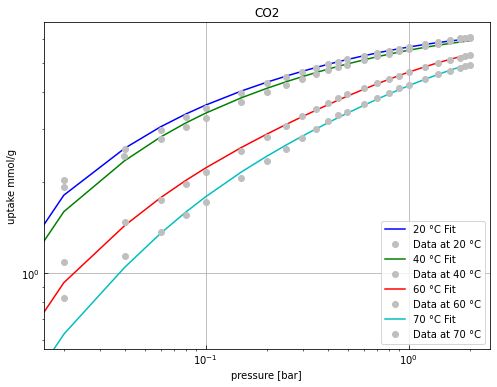

_________________________N2 RESULTS_____________________________
 
         This may affect accuracy of results.
         Henry region tolerance may be entered after log plot toggle parameter (default = 0.9999).

Henry regions found...


,Temperature (oC),Henry constant (mmol/(bar.g)),Upper limit (bar),Datapoints,R squared
0,20,1.786311,0.0413,3,0.98988
1,40,0.737650,0.0998,6,0.89800
2,60,1.361250,0.0602,4,0.99331
3,70,1.449495,0.0401,3,0.94505



Parameters found...


,Temp(K),qmax1 (mmol/g),qmax2 (mmol/g),h1 (J/mol),h2 (J/mol),b01 (1/bar),b02 (1/bar),R sq,mse
0,293,4.015,2.505,-1344.492,-1344.492,4.092e-02,4.092e-02,0.000000,0.047582
1,313,4.015,2.505,-1344.990,-1344.990,2.135e-02,2.135e-02,0.890875,0.002518
2,333,4.015,2.505,-1347.054,-1347.054,2.345e-02,2.345e-02,0.677647,0.006490
3,343,4.015,2.505,-1347.263,-1347.263,2.193e-02,2.193e-02,0.711407,0.005053


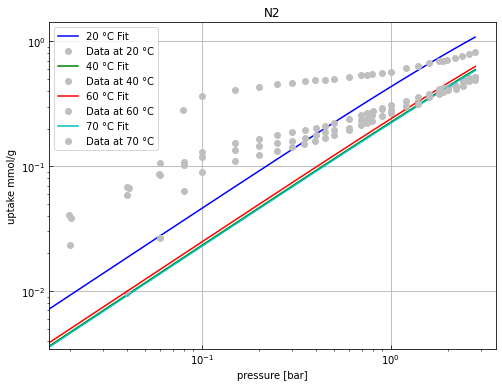

[4.014630292723778, 2.505314307413989, -35217.44716452572, 1583.311674497658, 1.9457396705613306e-05, 4.219828966561882, -1344.4917177951777, -1344.4917177951777, 0.040915007100948086, 0.040915007100948086]


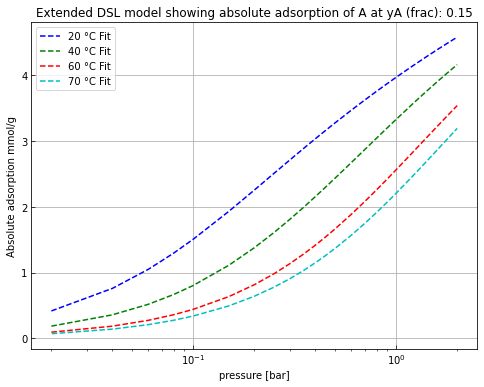

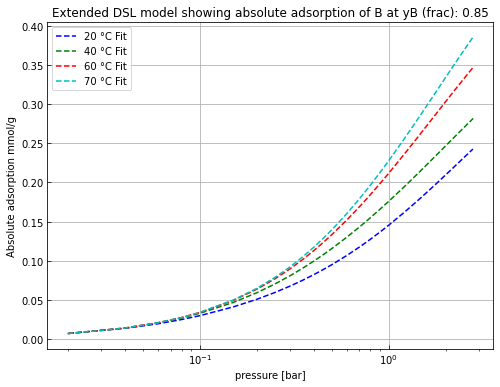

In [32]:
# Importing dataframes, here any number of data frames are accepted greater than or equal to 1
df1 = pd.read_csv('zeo_CO2_experimental.csv')
df2 = pd.read_csv('zeo_N2_experimental.csv')

#df1 = pd.read_csv('Computational Data (EPFL) CO2.csv')
#df2 = pd.read_csv('Computational Data (EPFL) N2.csv')

df_list = [df1, df2]
#temps = [0, 25, 50]  
temps = [20, 40, 60, 70]
# Need to input the dataframe as a list into the class
# Lists for pressure and uptake keys are also required

compnames = ['CO2', 'N2'] #Temp in C
meth = 'tnc' # Optional picking mathematical method for fitting (default is leastsq)
#initial guess values#
#       [q1    q2     b1      b2]
guess = [4.014630251577328, 2.5053142871054255, 7.663656259628368, 7.663655158791659] #Optional initial guess values for fitting

#keyUptakes = ['Uptake (mmol/g)_13X_10 (°C)', 'Uptake (mmol/g)_13X_40 (°C)', 'Uptake (mmol/g)_13X_100 (°C)']
#keyPressures = ['Pressure (bar)', 'Pressure (bar)', 'Pressure (bar)']

keyUptakes = ['Uptake1', 'Uptake2', 'Uptake3', 'Uptake4']
keyPressures = ['Pressure1', 'Pressure2', 'Pressure3', 'Pressure4']

params = temps, guess, keyPressures, keyUptakes, compnames, df_list, True, 0.9999, meth, 'extend', 0.15

fitDSL = DSL_fit(*params)
alpmof = fitDSL.fit_isotherm(*params)


In [15]:
# File converter

class FileConvert:
    def __init__(self, filenames, filetype, new_name):
        self.filenames = filenames
        self.filetype = filetype
        self.new_name = new_name
        
    def convert(self, filenames, filetype, new_name):
        df_list = []
        if filetype == 'json':
            for i in range(len(filenames)):
                df_list.append(pd.read_json(filenames[i]+'.json'))
            df = pd.concat(df_list, axis=1, join="inner")
            df.to_csv(new_name, index=False)
            print('Conversion successful')
        if filetype == 'csv':
            for i in range(len(filenames)):
                df_list.append(pd.read_json(filenames[i]+'.csv'))
            df = pd.concat([df_list], axis=1, join="inner")
            df.to_csv(new_name, index=False)
            print('Conversion successful')
    
filenames = ['zeo_273_N2', 'zeo_298_N2', 'zeo_323_N2']
filetype = 'json'
new_name = 'zeo_N2.csv'

convertfile = FileConvert(filenames, filetype, new_name)
convertfile.convert(filenames, filetype, new_name)

Conversion successful


# Extended DSL for binary co-adsorption (in progress)

In [ ]:
yA = 0.15
x = np.array([x/1000 for x in range(1,100000,1)])
#tempsK = [t+273 for t in temps]

farpars = [3.156, 2.244, -47612.9, -38545.6, 9.233e-07, 4.884e-07, 
           -16059.7, -16059.7, 5.8550e-05, 5.8550e-05]

#farpars = [3.875, 3.221, -45195.4, -36214.2, 1.157e-06, 8.147e-07,
         # -15349.9, -15349.9, 6.1508e-05, 6.150e-05]
#q1A, q2A, h1A, h2A, b01A, b02A,      h1B, h2B, b01B, b02B, yA

q_starA_283K = ext_dslA(x, 283, *farpars, yA)
q_starA_303K = ext_dslA(x, 313, *farpars, yA)
q_starA_333K = ext_dslA(x, 373, *farpars, yA)

xaxis = 'pressure [bar]'
yaxis = 'Absolute adsorption mmol/g'

##### Plotting results #####
plt.figure(figsize=(8, 6))
plt.title("Extended DSL model showing absolute adsorption of A at yA (frac): " + str(yA))
plt.tick_params(**tick_style)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel(xaxis)
plt.ylabel(yaxis)
plt.grid()
plt.plot(x, q_starA_283K, 'b--', label="10 $^{o}C$ Fit")
plt.plot(x, q_starA_303K, 'g--', label="30 $^{o}C$ Fit")
plt.plot(x, q_starA_333K, 'r--', label="60 $^{o}C$ Fit")
plt.legend()

plt.show()

yB = 1 - yA

q_starB_283K = ext_dslB(x, 283, *farpars, yB)
q_starB_303K = ext_dslB(x, 303, *farpars, yB)
q_starB_333K = ext_dslB(x, 333, *farpars, yB)

##### Plotting results #####
plt.figure(figsize=(8, 6))
plt.title("Extended DSL model showing absolute adsorption of B at yB (frac): " + str(round(yB,2)))
plt.tick_params(**tick_style)
plt.xscale("log")
#plt.yscale("log")
plt.xlabel(xaxis)
plt.ylabel(yaxis)
plt.grid()
plt.plot(x, q_starB_283K, 'b--', label="10 $^{o}C$ Fit")
plt.plot(x, q_starB_303K, 'g--', label="30 $^{o}C$ Fit")
plt.plot(x, q_starB_333K, 'r--', label="60 $^{o}C$ Fit")
plt.legend()

plt.show()
